### Dependencies

In [1]:
# Use these commands to install required dependencies if necessary.

# !pip install pandas numpy matplotlib sklearn

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import sqlite3
import os
from pprint import pprint

from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
con = sqlite3.connect(os.path.join(os.getcwd(), "../Database/results.sqlite"))

### Pre-Processing

In [3]:
# Convert datatypes from string to appropriate numeric/date types, and display the Tweets table

tweet_df = pd.read_sql_query("SELECT * from scored_tweets WHERE category LIKE 'Gaming'", con)
tweet_df["date"] = tweet_df["date"].astype("datetime64")
tweet_df["count"] = tweet_df["count"].astype("int32")
tweet_df["score"] = tweet_df["score"].astype("int32")
tweet_df.head(10)

,category,date,score,count
0,Gaming,2020-04-09,0,30
1,Gaming,2020-04-15,10,10
2,Gaming,2020-05-05,31,90
3,Gaming,2020-05-21,10,90
4,Gaming,2020-05-27,20,60
5,Gaming,2020-05-31,30,110
6,Gaming,2020-06-03,10,110
7,Gaming,2020-06-09,10,30
8,Gaming,2020-06-14,20,290
9,Gaming,2020-06-17,95,191


In [4]:
# Display the Stocks table

stock_df = pd.read_sql_query("SELECT * from scored_stocks WHERE category LIKE 'Gaming'", con)
stock_df["agg_percent"] = pd.to_numeric(stock_df["agg_percent"], downcast="float")
stock_df["date"] = stock_df["date"].astype("datetime64")
stock_df.head(10)

,category,date,agg_percent
0,Gaming,2020-04-06,1.062
1,Gaming,2020-04-09,-0.188
2,Gaming,2020-04-15,2.501
3,Gaming,2020-05-05,1.090
4,Gaming,2020-05-21,-2.102
5,Gaming,2020-05-27,2.007
6,Gaming,2020-06-03,-3.454
7,Gaming,2020-06-09,0.807
8,Gaming,2020-06-17,1.088
9,Gaming,2020-06-25,-0.562


In [5]:
# Merge the Tweets and Stocks table based on category and date.

merged_df = pd.merge(tweet_df, stock_df,on=["category", "date"]) 
merged_df = merged_df.sort_values(by=["category", "date"]).reset_index(drop=True)
merged_df

,category,date,score,count,agg_percent
0,Gaming,2020-04-07,-30,110,-0.756
1,Gaming,2020-04-08,28,106,-0.140
2,Gaming,2020-04-09,0,30,-0.188
3,Gaming,2020-04-13,20,40,3.454
4,Gaming,2020-04-14,0,70,0.205
...,...,...,...,...,...
412,Gaming,2022-03-15,-10,70,1.393
413,Gaming,2022-03-16,0,40,2.069
414,Gaming,2022-03-17,0,10,1.409
415,Gaming,2022-03-18,0,20,1.617


In [6]:
# Drop extraneous columns of information.

merged_df['norm_score'] = merged_df['score']/merged_df['count']
df = merged_df.drop(columns = ['category'])
df.head(10)

,date,score,count,agg_percent,norm_score
0,2020-04-07,-30,110,-0.756,-0.272727
1,2020-04-08,28,106,-0.140,0.264151
2,2020-04-09,0,30,-0.188,0.000000
3,2020-04-13,20,40,3.454,0.500000
4,2020-04-14,0,70,0.205,0.000000
5,2020-04-15,10,10,2.501,1.000000
6,2020-04-16,10,60,2.919,0.166667
7,2020-04-17,140,210,-1.336,0.666667
8,2020-04-20,20,50,0.496,0.400000
9,2020-04-21,10,30,-1.229,0.333333


In [7]:
# Normalize the data.

scaler = StandardScaler() 
arr_scaled = scaler.fit_transform(df) 
df_scaled = pd.DataFrame(arr_scaled, columns=df.columns,index=df.index)
df_scaled.head(10)

TypeError: invalid type promotion

### Correlation Analysis

In [8]:
# Perform a correlation analysis on the consolidated data.

df = df_scaled
df.corr(method="spearman")

,score,count,agg_percent,norm_score
score,1.000000,0.273800,0.084321,0.926648
count,0.273800,1.000000,-0.003336,0.086483
agg_percent,0.084321,-0.003336,1.000000,0.101121
norm_score,0.926648,0.086483,0.101121,1.000000


### Visualizations

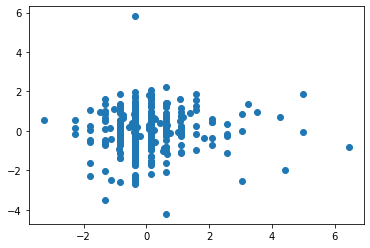

In [9]:
plt.scatter(df["score"], df["agg_percent"])

<IPython.core.display.Javascript object>


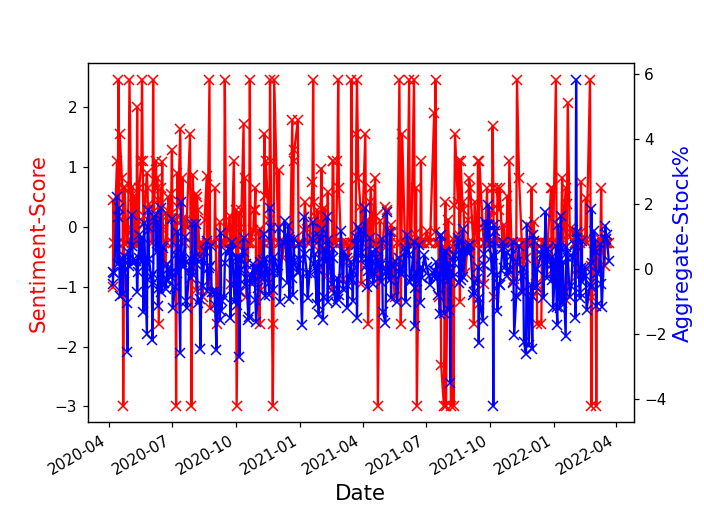

In [10]:
%matplotlib notebook
fig,ax = plt.subplots()
fig.autofmt_xdate()

ax.plot(merged_df.date, df.norm_score, color="red", marker="x")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("Sentiment-Score",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
ax2.plot(merged_df.date, df.agg_percent,color="blue",marker="x")
ax2.set_ylabel("Aggregate-Stock%",color="blue",fontsize=14)
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 50
plt.show()


In [12]:
plt.savefig('stock-tweet-scatter.png')

In [18]:
# group by year and month
sample_df = df
sample_df['year'] = sample_df['date'].astype(str).str.slice(0,4)
sample_df['month'] = sample_df['date'].astype(str).str.slice(0,7)
sample_df

grouped_year = sample_df.groupby('year')
grouped_month = sample_df.groupby('month')
grouped_month.get_group('2020-04')

,date,score,count,agg_percent,norm_score,year,month
0,2020-04-07,149,217,-2.83000,0.686636,2020,2020-04
1,2020-04-08,-51,416,0.83600,-0.122596,2020,2020-04
2,2020-04-09,33,275,-1.33975,0.120000,2020,2020-04
3,2020-04-13,32,453,1.74775,0.070640,2020,2020-04
4,2020-04-14,192,585,1.28475,0.328205,2020,2020-04
5,2020-04-15,67,386,0.28625,0.173575,2020,2020-04
6,2020-04-16,12,320,0.00450,0.037500,2020,2020-04
7,2020-04-17,16,462,-0.88175,0.034632,2020,2020-04
8,2020-04-20,22,449,-0.18850,0.048998,2020,2020-04
9,2020-04-21,25,238,-2.71775,0.105042,2020,2020-04


In [23]:
for year in sample_df.year.unique():
    temp_df = grouped_year.get_group(year)
    value = temp_df.corr(method="pearson")
    print({year})
    print(value, end="\n\n")

{'2020'}
                score     count  agg_percent  norm_score
score        1.000000  0.226041     0.101405    0.857649
count        0.226041  1.000000     0.017261    0.085977
agg_percent  0.101405  0.017261     1.000000    0.041314
norm_score   0.857649  0.085977     0.041314    1.000000

{'2021'}
                score     count  agg_percent  norm_score
score        1.000000  0.405023     0.012946    0.679569
count        0.405023  1.000000    -0.003132    0.120742
agg_percent  0.012946 -0.003132     1.000000    0.069493
norm_score   0.679569  0.120742     0.069493    1.000000

{'2022'}
                score     count  agg_percent  norm_score
score        1.000000 -0.076267     0.211148    0.960814
count       -0.076267  1.000000    -0.051688   -0.135932
agg_percent  0.211148 -0.051688     1.000000    0.249764
norm_score   0.960814 -0.135932     0.249764    1.000000



In [25]:
for month in sample_df.month.unique():
    temp_df = grouped_month.get_group(month)
    value = temp_df.corr(method="pearson")
    print({month})
    print(value, end="\n\n")

{'2020-04'}
                score     count  agg_percent  norm_score
score        1.000000  0.002888    -0.101575    0.865717
count        0.002888  1.000000    -0.003122   -0.272932
agg_percent -0.101575 -0.003122     1.000000   -0.316126
norm_score   0.865717 -0.272932    -0.316126    1.000000

{'2020-05'}
                score     count  agg_percent  norm_score
score        1.000000  0.785732     0.301455    0.903368
count        0.785732  1.000000     0.188477    0.695148
agg_percent  0.301455  0.188477     1.000000    0.220688
norm_score   0.903368  0.695148     0.220688    1.000000

{'2020-06'}
                score     count  agg_percent  norm_score
score        1.000000  0.137546     0.166022    0.960794
count        0.137546  1.000000    -0.377622    0.013589
agg_percent  0.166022 -0.377622     1.000000    0.260434
norm_score   0.960794  0.013589     0.260434    1.000000

{'2020-07'}
                score     count  agg_percent  norm_score
score        1.000000  0.079225    -0

In [7]:
# group by year and month
sample_df = df
sample_df['year'] = sample_df['date'].astype(str).str.slice(0,4)
sample_df['month'] = sample_df['date'].astype(str).str.slice(0,7)
sample_df

grouped_year = sample_df.groupby('year')
grouped_month = sample_df.groupby('month')
grouped_month.get_group('2020-04')

,date,score,count,agg_percent,norm_score,year,month
0,2020-04-07,-30,110,-0.756,-0.272727,2020,2020-04
1,2020-04-08,28,106,-0.140,0.264151,2020,2020-04
2,2020-04-09,0,30,-0.188,0.000000,2020,2020-04
3,2020-04-13,20,40,3.454,0.500000,2020,2020-04
4,2020-04-14,0,70,0.205,0.000000,2020,2020-04
5,2020-04-15,10,10,2.501,1.000000,2020,2020-04
6,2020-04-16,10,60,2.919,0.166667,2020,2020-04
7,2020-04-17,140,210,-1.336,0.666667,2020,2020-04
8,2020-04-20,20,50,0.496,0.400000,2020,2020-04
9,2020-04-21,10,30,-1.229,0.333333,2020,2020-04


In [8]:
for year in sample_df.year.unique():
    temp_df = grouped_year.get_group(year)
    value = temp_df.corr(method="pearson")
    print({year})
    print(value, end="\n\n")

{'2020'}
                score     count  agg_percent  norm_score
score        1.000000  0.588065     0.089019    0.570711
count        0.588065  1.000000    -0.012234    0.077648
agg_percent  0.089019 -0.012234     1.000000    0.199252
norm_score   0.570711  0.077648     0.199252    1.000000

{'2021'}
                score     count  agg_percent  norm_score
score        1.000000  0.108100     0.089729    0.660140
count        0.108100  1.000000    -0.014737   -0.049354
agg_percent  0.089729 -0.014737     1.000000    0.059247
norm_score   0.660140 -0.049354     0.059247    1.000000

{'2022'}
                score     count  agg_percent  norm_score
score        1.000000  0.164205    -0.163487    0.673134
count        0.164205  1.000000    -0.033612    0.012765
agg_percent -0.163487 -0.033612     1.000000   -0.129984
norm_score   0.673134  0.012765    -0.129984    1.000000



In [9]:
for month in sample_df.month.unique():
    temp_df = grouped_month.get_group(month)
    value = temp_df.corr(method="pearson")
    print({month})
    print(value, end="\n\n")

{'2020-04'}
                score     count  agg_percent  norm_score
score        1.000000  0.665638    -0.052448    0.631085
count        0.665638  1.000000    -0.103627    0.107704
agg_percent -0.052448 -0.103627     1.000000    0.298391
norm_score   0.631085  0.107704     0.298391    1.000000

{'2020-05'}
                score     count  agg_percent  norm_score
score        1.000000  0.627480    -0.507131    0.354338
count        0.627480  1.000000    -0.304419   -0.255000
agg_percent -0.507131 -0.304419     1.000000   -0.157897
norm_score   0.354338 -0.255000    -0.157897    1.000000

{'2020-06'}
                score     count  agg_percent  norm_score
score        1.000000  0.760334     0.286538    0.523353
count        0.760334  1.000000     0.006373    0.096296
agg_percent  0.286538  0.006373     1.000000    0.360604
norm_score   0.523353  0.096296     0.360604    1.000000

{'2020-07'}
                score     count  agg_percent  norm_score
score        1.000000  0.413354    -0